# ABU量化系统使用文档 

<center>
        <img src="./image/abu_logo.png" alt="" style="vertical-align:middle;padding:10px 20px;"><font size="6" color="black"><b>第13节 量化技术分析应用</b></font>
</center>

-----------------


作者: 阿布

阿布量化版权所有 未经允许 禁止转载

[abu量化系统github地址](https://github.com/bbfamily/abu) (欢迎+star)

[本节ipython notebook](https://github.com/bbfamily/abu/tree/master/abupy_lecture)

量化交易的最大优势即为通过计算机强大的运算能力，在市场广度分析上占有绝对优势，通过历史规律的总结，在规律的基础上发现概率优势，形成良好投机优势，量化交易离不开技术分析，本节将主要示例一些常用的技术分析在abupy中的接口实现。

首先导入abupy本节使用模块：

In [1]:
# 基础库导入

from __future__ import print_function
from __future__ import division

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))
import abupy

# 使用沙盒数据，目的是和书中一样的数据环境
abupy.env.enable_example_env_ipython()

enable example env will only read RomDataBu/csv


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from abupy import abu, ml, nd, tl, pd_resample, AbuML, AbuMLPd, AbuMetricsBase
from abupy import AbuFactorAtrNStop, AbuFactorPreAtrNStop, AbuFactorCloseAtrNStop, AbuFactorBuyBreak
from abupy import ABuSymbolPd, ABuScalerUtil, get_price, ABuMarketDrawing, ABuKLUtil

将abupy内置沙盒数据中美股，A股，港股市场中的symbol都列出来，稍后绘制这些symbol的阻力线，支持线：

In [4]:
us_choice_symbols = ['usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usWUBA', 'usVIPS']
cn_choice_symbols = ['002230', '300104', '300059', '601766', '600085', '600036', '600809', '000002', '002594', '002739']
hk_choice_symbols = ['hk03333', 'hk00700', 'hk02333', 'hk01359', 'hk00656', 'hk03888', 'hk02318']

In [5]:
import numpy as np
from threadpoolctl import threadpool_info

# 打印 NumPy 配置，特别是 BLAS 和 OpenBLAS
print(np.show_config())

# 打印线程池信息
print(threadpool_info())


Build Dependencies:
  blas:
    detection method: pkgconfig
    found: true
    include directory: /Users/liuyiling/anaconda3/envs/quantstrat/include
    lib directory: /Users/liuyiling/anaconda3/envs/quantstrat/lib
    name: openblas
    openblas configuration: USE_64BITINT= DYNAMIC_ARCH=1 DYNAMIC_OLDER= NO_CBLAS=
      NO_LAPACK=0 NO_LAPACKE= NO_AFFINITY=1 USE_OPENMP=0 CORE2 MAX_THREADS=128
    pc file directory: /Users/liuyiling/anaconda3/envs/quantstrat/lib/pkgconfig
    version: 0.3.21
  lapack:
    detection method: internal
    found: true
    include directory: unknown
    lib directory: unknown
    name: dep140590790269056
    openblas configuration: unknown
    pc file directory: unknown
    version: 1.26.4
Compilers:
  c:
    args: -march=core2, -mtune=haswell, -mssse3, -ftree-vectorize, -fPIC, -fPIE, -fstack-protector-strong,
      -O2, -pipe, -isystem, /Users/liuyiling/anaconda3/envs/quantstrat/include, -fdebug-prefix-map=/var/folders/c_/qfmhj66j0tn016nkx_th4hxm0000gp/T/ab

### 1. 阻力线，支撑线自动绘制

对趋势技术分析很熟悉的朋友们对上升趋势线，下降趋势线，阻力线, 支撑线这些概念很熟悉，但是从理论出发，很难有两个人画出的线是完全一样的，即使是一个人不同的时候去画也会有精度的误差，使用数据分析自己画出趋势与阻力是对量化分析的最根本诠释，人对数据的敏感度一定不如死的机器，因为人是有感情的，也许你会画出自己想要的趋势线阻力线来骗自己，再坚持一下马上就阻力了就上去了等等，快交给机器吧！别自己画了!

封装一个函数默认绘制usTSLA的趋势线，主要将AbuTLine中绘制阻力线，支撑线的函数进行封装，代码如下所示：

support pos::0.4%

FloatProgress(value=0.0)

resistance pos::0.4%

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in add
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: inval

FloatProgress(value=0.0)

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: overflow encountered in multiply
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in add
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: o

resistance pos::100.0%

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/sklearn/cluster/_kme

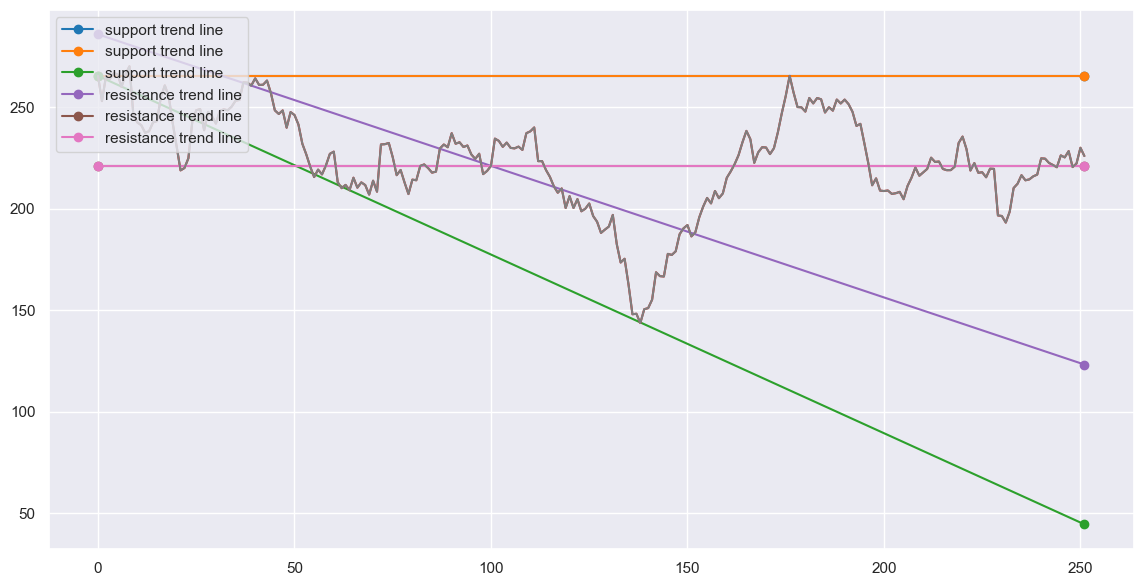

In [6]:
def plot_trend(symbol='usTSLA', n_folds=1, only_last=False, how='both', show_step=False):
    n_folds = int(n_folds)
    # 获取symbol的n_folds年数据
    kl = ABuSymbolPd.make_kl_df(symbol, n_folds=n_folds)
    # 构造技术线对象
    kl_tl = tl.AbuTLine(kl.close, 'kl')
    if how == 'support':
        # 只绘制支持线
        kl_tl.show_support_trend(only_last=only_last, show=True, show_step=show_step)
    elif how == 'resistance':
        # 只绘制阻力线
        kl_tl.show_resistance_trend(only_last=only_last, show=True, show_step=show_step)
    else:
        # 支持线和阻力线都绘制
        kl_tl.show_support_resistance_trend(only_last=only_last, show=True, show_step=show_step)
plot_trend()

上面的函数绘制了tsla一年中的支撑线和阻力线，由于一年内会存在可能会存在多条阻力线，以及多条支撑线，有些支撑线也已经明显破位，比如上面浅蓝色那根早期的支撑线，还有黄色的早期阻力线，如果只想绘制最近的阻力线和支持线，可以使用only_last参数，如下所示，最近的阻力线红色，最近的支持线蓝色，可以发现两根线马上就要相交了：

support pos::0.4%

/Users/liuyiling/Documents/GitHub/abu/abupy/TLineBu/ABuTLine.py:105: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  line = pd.Series(line).fillna(method='bfill')


FloatProgress(value=0.0)

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in add
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: inval

resistance pos::0.4%

FloatProgress(value=0.0)

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: overflow encountered in multiply
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in add
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: o

resistance pos::100.0%

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: overflow encountered in multiply
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in add
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: o

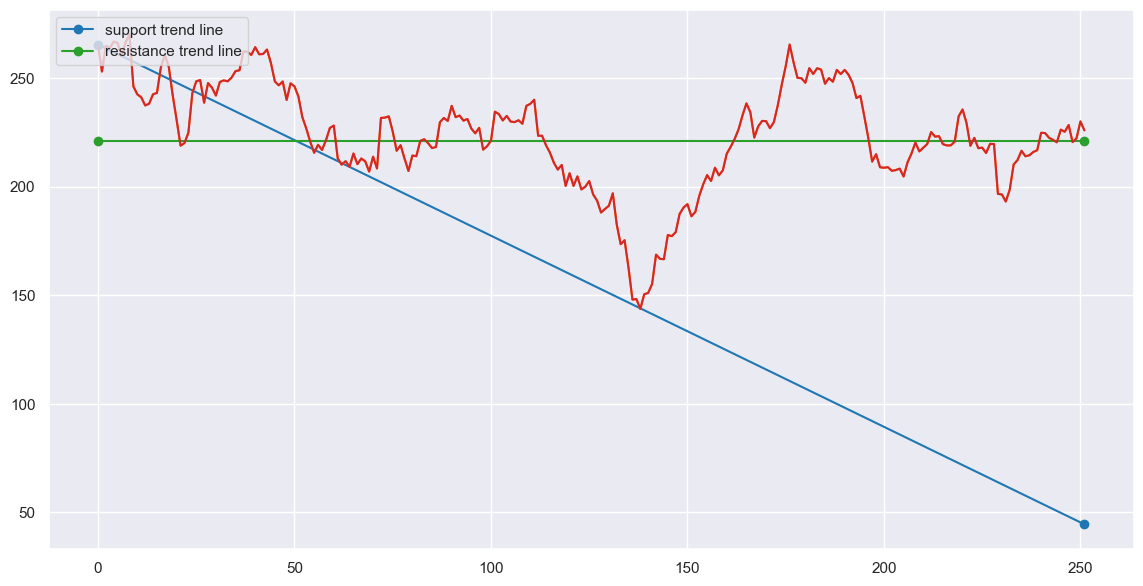

In [7]:
plot_trend(only_last=True)

abupy中阻力线，支撑线基本绘制原理如下所示：

* 首先分析原始曲线的最佳拟合次数，根据最佳拟合次数对曲线进行多项式拟合，
* 拟合后的函数通过bfgs算法寻找阻力位支撑位，即过滤筛选出趋势关键骨架点
* 对趋势关键骨架点通过聚类算法(kmean)以及方差最优计算，获取最终的两个关键点，两点绘制阻力线或者支撑线

下面通过参数show_step为True将绘制阻力线，支撑线的中间分析步骤进行绘制，如下所示：

* 下第一图即为根据最佳拟合次数对曲线得到的拟合函数，通过bfgs算法滤筛选出趋势关键骨架点
* 下第二图通过聚类算法以及方差最优计算出的聚类结果，不同的颜色代表不同的聚类簇
* 下第三图找到支撑线最终的两个关键点，两点绘制支撑线
* 下第四图找到阻力线最终的两个关键点，两点绘制阻力线

更多实现细节请阅读源代码AbuTLine以及ABuTLExecute

support pos::0.4%

/Users/liuyiling/Documents/GitHub/abu/abupy/TLineBu/ABuTLine.py:105: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  line = pd.Series(line).fillna(method='bfill')


FloatProgress(value=0.0)

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in add
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: inval

resistance pos::0.4%

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in add
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: inval

FloatProgress(value=0.0)

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: overflow encountered in multiply
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in add
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: o

resistance pos::4.76%

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: overflow encountered in multiply
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: overflow encountered in multiply
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1175: RuntimeWarning: invalid value encountered in add
  return c0 + c1*x
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: invalid value encountered in add
  c1 = tmp + c1*x2
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/numpy/polynomial/chebyshev.py:1174: RuntimeWarning: o

resistance pos::100.0%

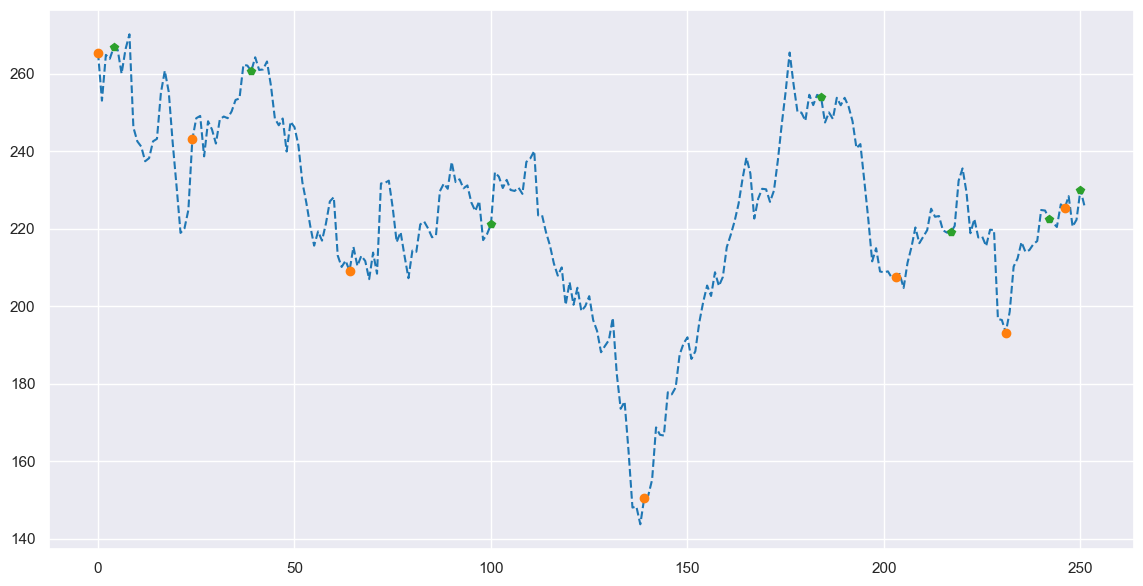

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/sklearn/cluster/_kme

<Figure size 1400x700 with 0 Axes>

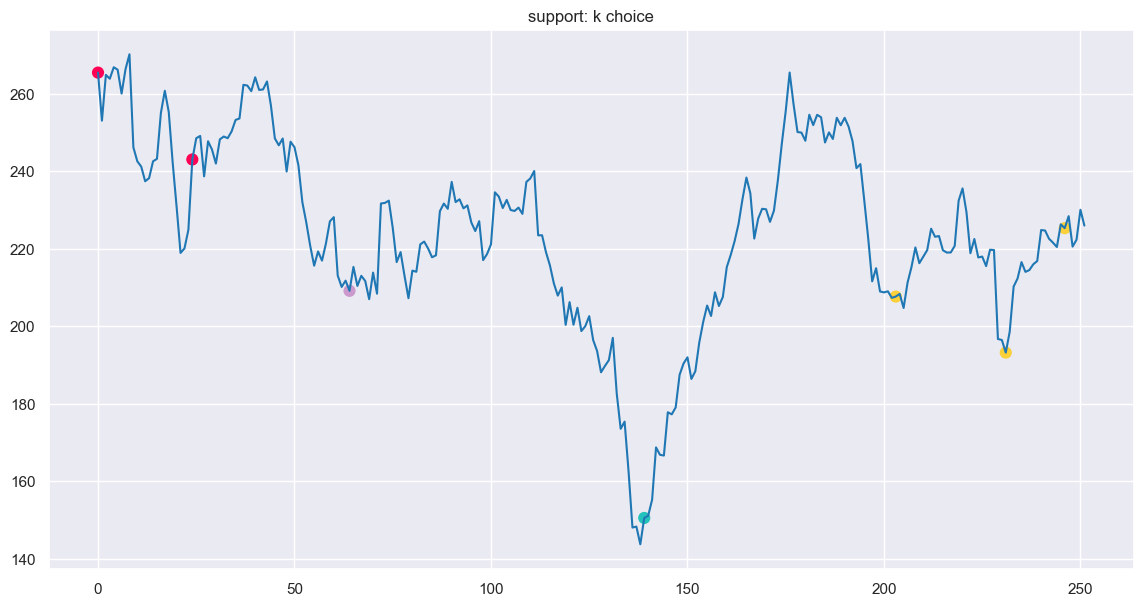

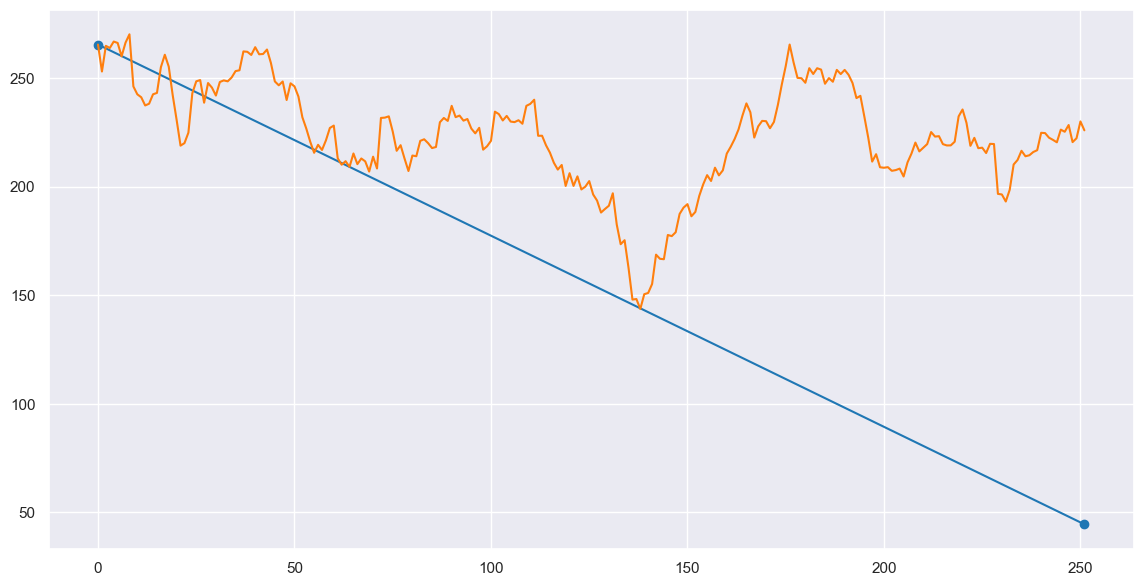

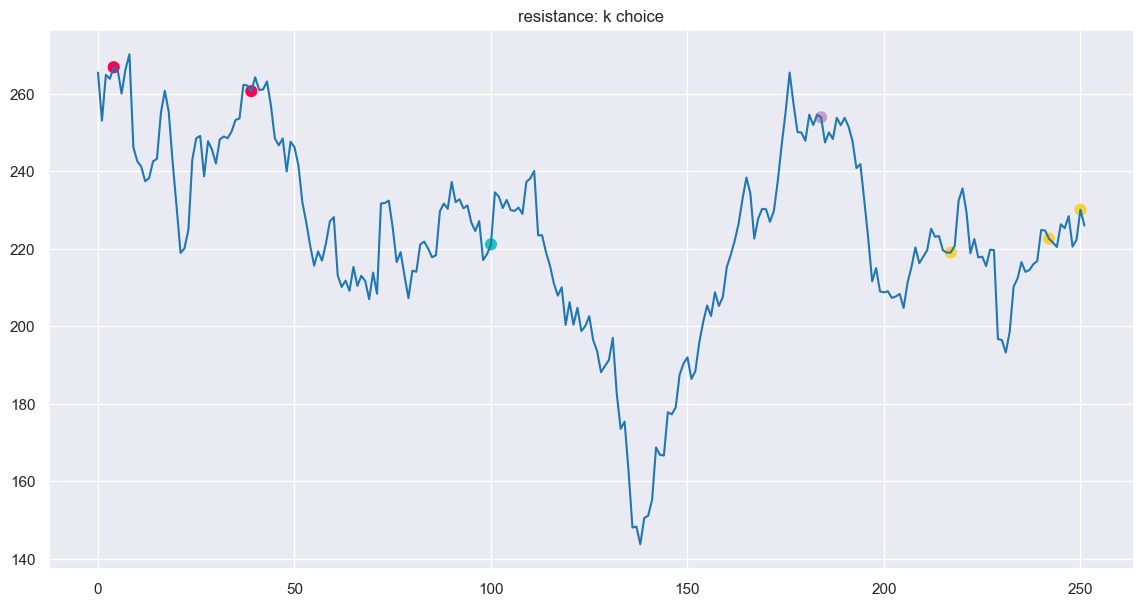

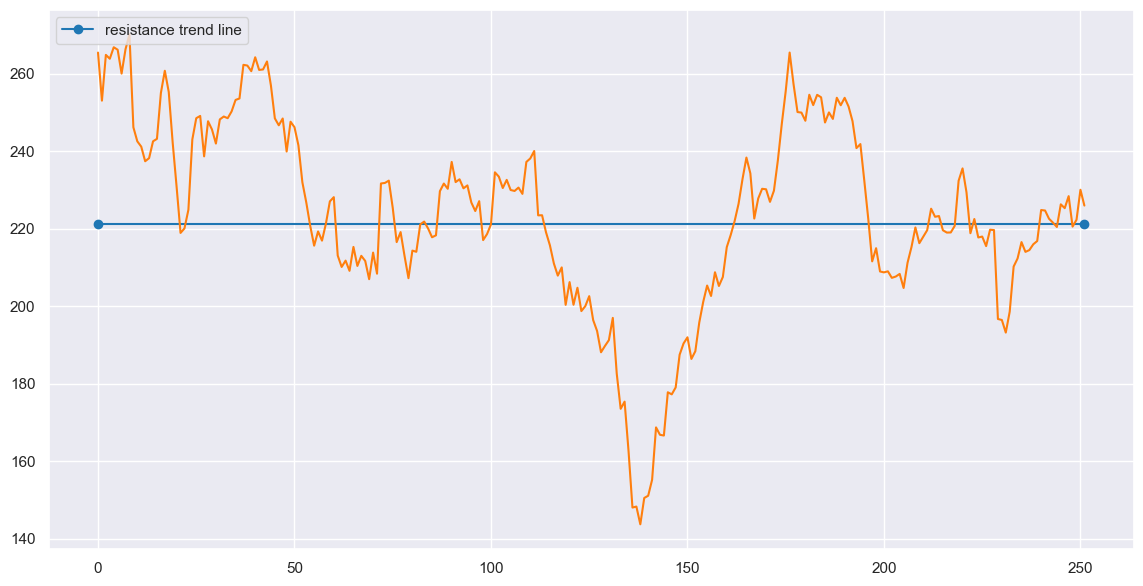

In [8]:
plot_trend(only_last=True, show_step=True)

下面尝试绘制其它symbol的趋势线，一个个参数换太麻烦了，使用ipywidgets进行交互，如下所示：

In [9]:
from ipywidgets import interact, Checkbox 


symbol_range = us_choice_symbols + cn_choice_symbols + hk_choice_symbols
n_folds_range =  ['1', '2', '3', '4', '5']
only_last_check = Checkbox(False)
show_step_check = Checkbox(False)
how_range = ['both', 'support', 'resistance']

_ = interact(plot_trend, symbol=symbol_range, n_folds=n_folds_range, 
             only_last=only_last_check, how=how_range, show_step=show_step_check)

/Users/liuyiling/anaconda3/envs/quantstrat/lib/python3.9/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(Dropdown(description='symbol', options=('usTSLA', 'usNOAH', 'usSFUN', 'usBIDU', 'usAAPL'…

通过阻力线，支撑线的确定，可以实现均值回复类型的择时策略，比如在支撑线位置买入股票，之后在阻力线位置卖出股票。

但是并不建议像上面这种简单实现，因为阻力线和支撑线的确定本身即存在很大分歧，即在本节初始说的，很难有两个人画出的线是完全一样的，即使是一个人不同的时候去画也会有精度的误差，使用程序去绘制的好处是规避感情，人去绘制很容易绘制出自己希望的走势，看上去好像还挺有道理。

建议的使用方式是类似阀值支持度的方式，比如在一个均值回复策略中：使用黄金分割线的0.382附近做为初始检测买入点，这时候可以同时度量一下现在是否同样处在支撑线附近，且离阻力线足够远，同时做为买入条件，也可以再并上其它条件，形成一个苛刻的买入策略，即买入条件为：

1. 黄金分割线的0.382附近
2. 支撑线附近
3. 离阻力线足够远
4. .....................
5. .....................

量化分析的最大长处即是通过计算机强大的运算能力，在广度上占有绝对优势，即如果是传统人脑的分析方式上述方法是行不通的，因为人的能力范围内所能涉及的交易目标数量有限，上述苛刻条件可能导致交易者很长时间无交易可做，但通过量化交易可以在短时间内完成对不同市场的不同交易目标分析，林子大了什么鸟都有，一定会有符合条件的买入目标。

在之后的章节会使用阻力线和支撑线编写一个完整的择时选股策略，，请关注公众号的更新提醒。

### 2. 跳空技术分析

跳空缺口是指股价开盘价高于昨天的最高价或低于昨天的最低价，使K线图出现空档的现象。

* 普通缺口：特点就是很快被回补，价格在几天之内就会回补
* 突破缺口：当价格和成交量伴随跳空（向上或者向下）跳出震荡区，则预示着新趋势的形成
* 衰竭缺口：缺口没有很快回补，走势也反复无常，最终慢慢的回补缺口，预示着市场走势将可能剧烈的反转

本节只从使用的角度出发，示例abupy中的跳空统计分析接口的使用：

/Users/liuyiling/Documents/GitHub/abu/abupy/TLineBu/ABuTLJump.py:82: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  change_mean.fillna(method='pad', inplace=True)
/Users/liuyiling/Documents/GitHub/abu/abupy/TLineBu/ABuTLJump.py:84: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  change_mean.fillna(method='bfill', inplace=True)
/Users/liuyiling/Documents/GitHub/abu/abupy/TLineBu/ABuTLJump.py:112: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  volume_mean.fillna(method='pad', inplace=True)
/Users/liuyiling/Documents/GitHub/abu/abupy/TLineBu/ABuTLJump.py:114: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  volume_mean.fillna(method='bfill', inpl

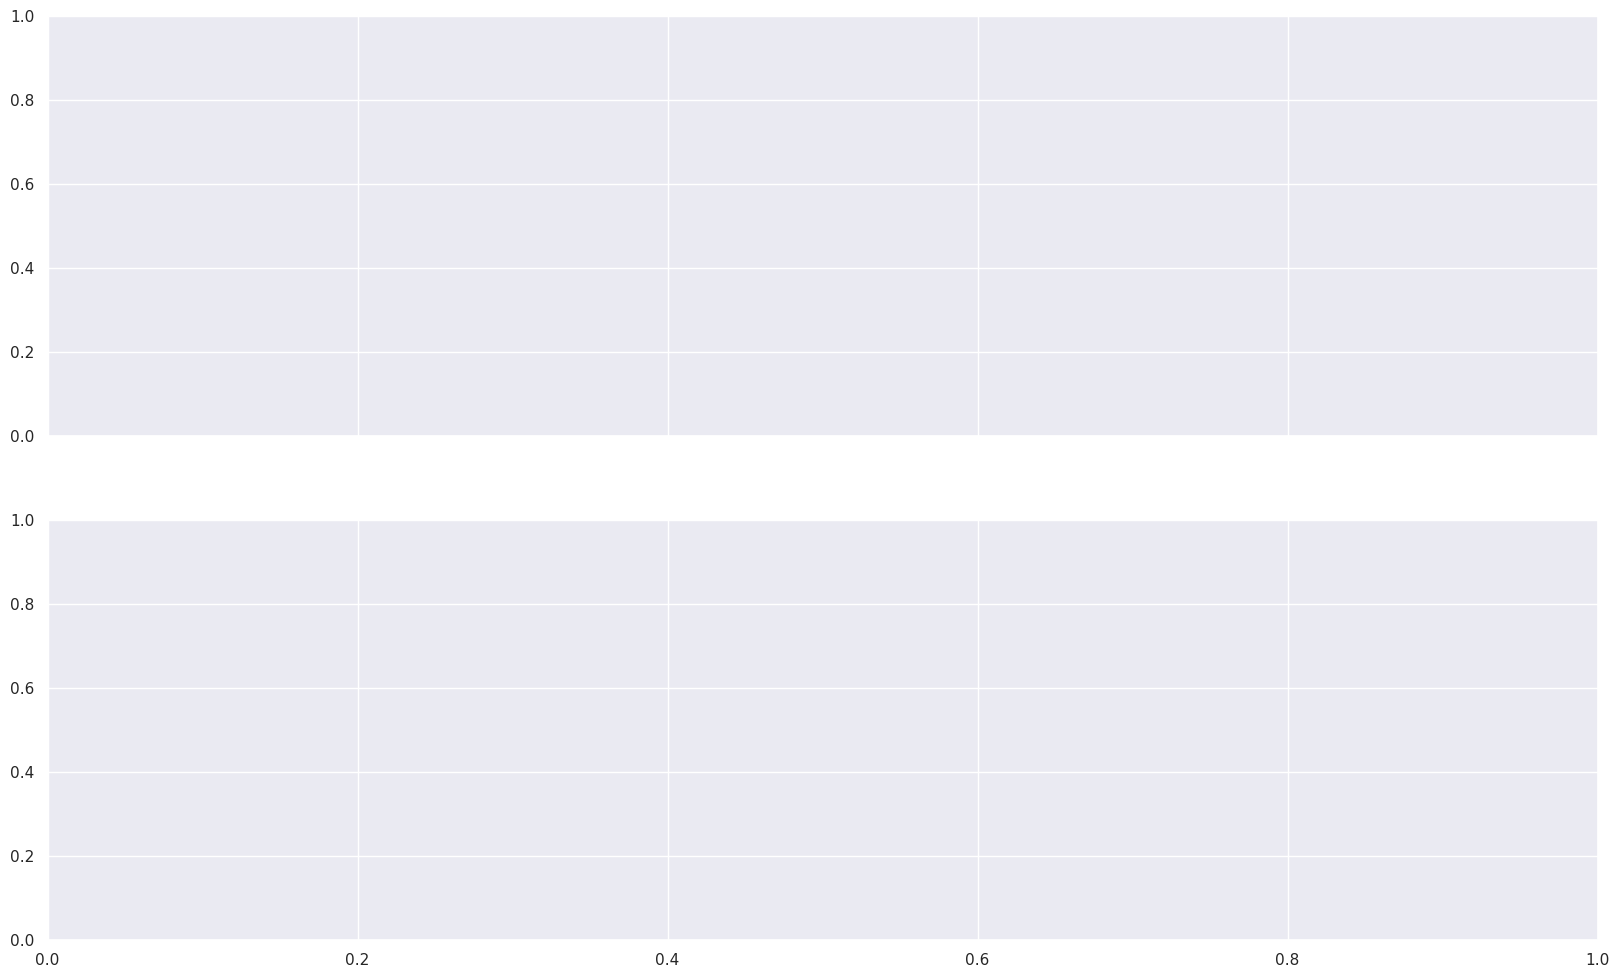

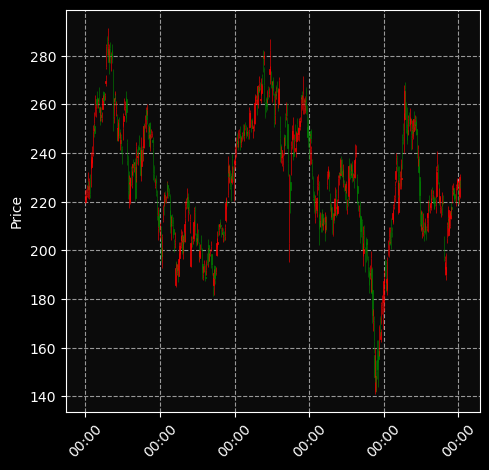

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


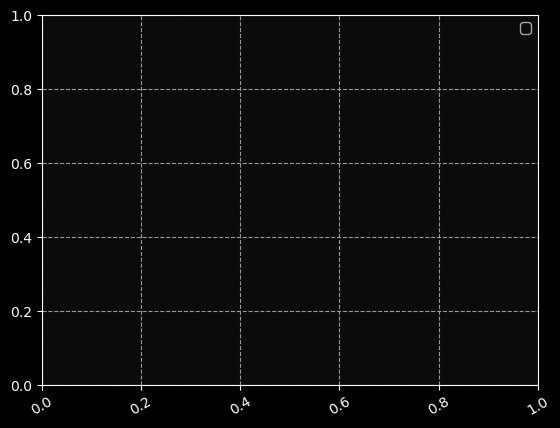

In [10]:
tsla_df = ABuSymbolPd.make_kl_df('usTSLA')
jumps = tl.jump.calc_jump(tsla_df)

缺口最大的意义在于存在很强的支撑或者阻力，你可以发现上述实现的缺口选取了很多点，那首先做做减法，选取那些阻力支撑最强的缺口，从代码来说就是jump_power最大的那些缺口。

可以使用tl.jump.calc_jump_line()获取jump_power大于阀值的缺口，如下所示以2.8为跳空能量筛选阀值：

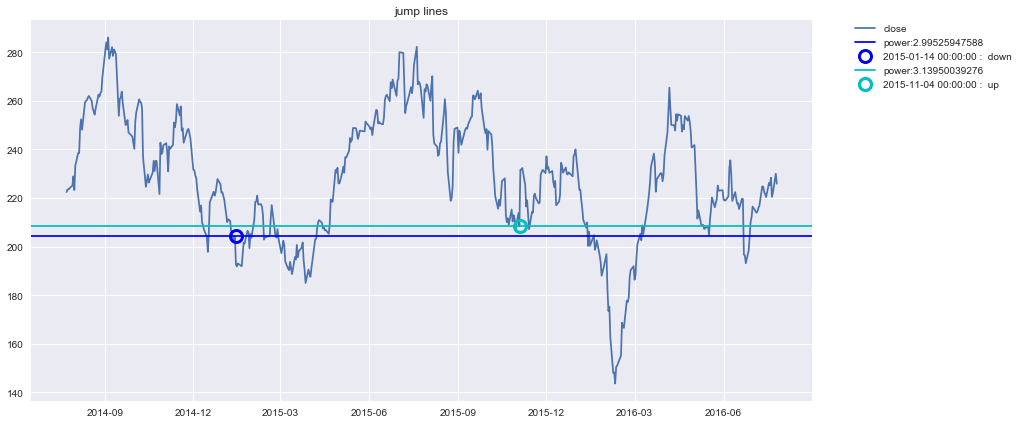

In [9]:
jump_pd = tl.jump.calc_jump_line(tsla_df, power_threshold=2.8)

tl.jump.calc_jump_line_weight()函数与上面使用的calc_jump_line()函数区别是根据时间权重重新计算了jump_power，也就比如一年前有个jump_power=2的缺口，昨天也有个jump_power=2的缺口，根据时间线性加权的结果，一年前的jump_power要远远小于2可能只有0.8了，但是昨天的缺口jump_power还是2。

使用时间加权的一个原因是随着时间的流逝，越远的记忆越淡忘，不管你当时有多懊悔多伤悲，另一个原因是针对同一个市场一支股票的交易者可能已经交替更换，新的交易者没有之前或惋惜或懊悔的记忆，每7年我们就是一个全新的自己，所有细胞血液更新一遍完成。

下面的代码使用tl.jump.calc_jump_line_weight()函数即时间加权方式，对缺口行进行过滤：

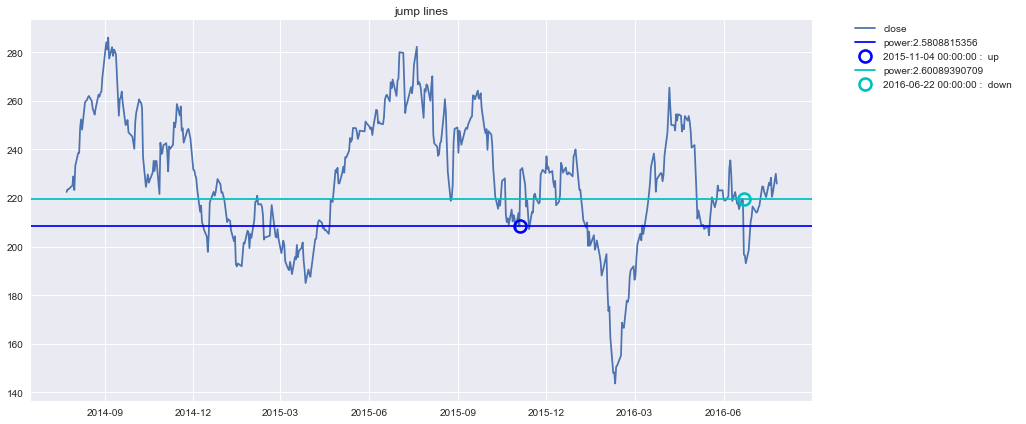

In [10]:
# sw[0]代表非时间因素的jump_power，sw[1]代表时间加权因素的jump_power，当sw[0]=1时与非加权方式相同，具体实现请参考源代码  
jump_pd = tl.jump.calc_jump_line_weight(tsla_df, sw=(0.5, 0.5))

得到跳空的缺口后，与上面所说的支撑线，阻力线的应用方式类似，可以直接做为策略触发点，也可以做为辅助判断条件使用。

### 3. 传统技术指标技术分析

abupy中内置了传统技术指标可视化及度量方法，如下示例，首先使用usTSLA进行回测，从回测结果中取出一个交易单：

In [11]:
# 设置初始资金数
read_cash = 1000000
# 买入因子依然延用向上突破因子
buy_factors = [{'xd': 60, 'class': AbuFactorBuyBreak},
               {'xd': 42, 'class': AbuFactorBuyBreak}]
# 卖出因子继续使用上一节使用的因子
sell_factors = [
    {'stop_loss_n': 1.0, 'stop_win_n': 3.0,
     'class': AbuFactorAtrNStop},
    {'class': AbuFactorPreAtrNStop, 'pre_atr_n': 1.5},
    {'class': AbuFactorCloseAtrNStop, 'close_atr_n': 1.5}
]

abu_result_tuple, kl_pd_manger = abu.run_loop_back(read_cash,
                                                   buy_factors,
                                                   sell_factors,
                                                   choice_symbols=['usTSLA'])

order = abu_result_tuple.orders_pd.iloc[0]

pid:56412 gen kl_pd complete:100.0%


TypeError: unsupported operand type(s) for &: 'DatetimeArray' and 'DatetimeArray'

绘制macd以及交易的买入卖出点位，如下所示：

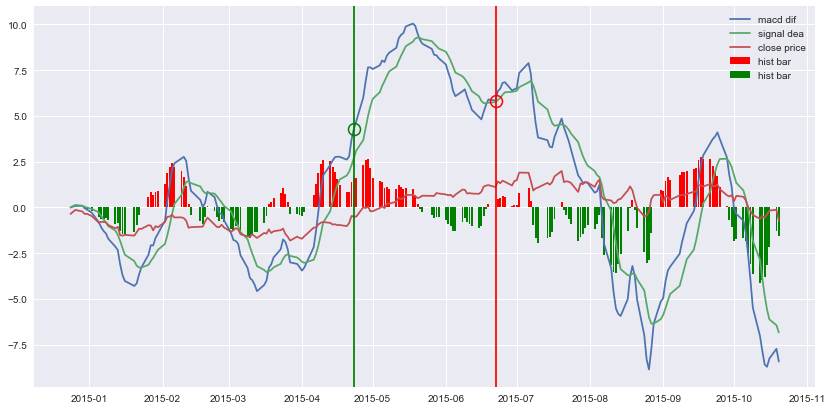

In [12]:
nd.macd.plot_macd_from_order(order)

绘制boll以及交易的买入卖出点位，如下所示：

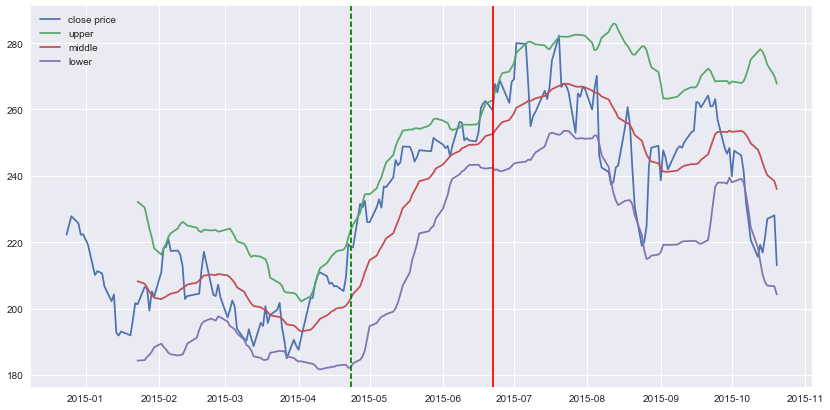

In [13]:
nd.boll.plot_boll_from_order(order)

绘制多条均线以及交易的买入卖出点位，如下所示：

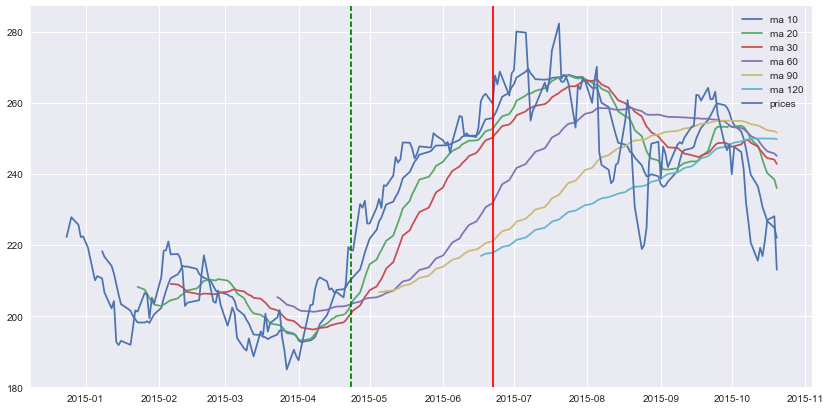

In [14]:
nd.ma.plot_ma_from_order(order, time_period=[10, 20, 30, 60, 90, 120])

abupy中内置的技术分析接口还有一些暂时没有示例，在之后的章节会陆续进行示例，请关注公众号的更新提醒。

#### abu量化文档目录章节

1. [择时策略的开发](http://www.abuquant.com/lecture/lecture_1.html)
2. [择时策略的优化](http://www.abuquant.com/lecture/lecture_2.html)
3. [滑点策略与交易手续费](http://www.abuquant.com/lecture/lecture_3.html)
4. [多支股票择时回测与仓位管理](http://www.abuquant.com/lecture/lecture_4.html)
5. [选股策略的开发](http://www.abuquant.com/lecture/lecture_5.html)
6. [回测结果的度量](http://www.abuquant.com/lecture/lecture_6.html)
7. [寻找策略最优参数和评分](http://www.abuquant.com/lecture/lecture_7.html)
8. [A股市场的回测](http://www.abuquant.com/lecture/lecture_8.html)
9. [港股市场的回测](http://www.abuquant.com/lecture/lecture_9.html)
10. [比特币，莱特币的回测](http://www.abuquant.com/lecture/lecture_10.html)
11. [期货市场的回测](http://www.abuquant.com/lecture/lecture_11.html)
12. [机器学习与比特币示例](http://www.abuquant.com/lecture/lecture_12.html)
13. [量化技术分析应用](http://www.abuquant.com/lecture/lecture_13.html)
14. [量化相关性分析应用](http://www.abuquant.com/lecture/lecture_14.html)
15. [量化交易和搜索引擎](http://www.abuquant.com/lecture/lecture_15.html)
16. [UMP主裁交易决策](http://www.abuquant.com/lecture/lecture_16.html)
17. [UMP边裁交易决策](http://www.abuquant.com/lecture/lecture_17.html)
18. [自定义裁判决策交易](http://www.abuquant.com/lecture/lecture_18.html)
19. [数据源](http://www.abuquant.com/lecture/lecture_19.html)
20. [A股全市场回测](http://www.abuquant.com/lecture/lecture_20.html)
21. [A股UMP决策](http://www.abuquant.com/lecture/lecture_21.html)
22. [美股全市场回测](http://www.abuquant.com/lecture/lecture_22.html)
23. [美股UMP决策](http://www.abuquant.com/lecture/lecture_23.html)

abu量化系统文档教程持续更新中，请关注公众号中的更新提醒。

#### 《量化交易之路》目录章节及随书代码地址

1. [第二章 量化语言——Python](https://github.com/bbfamily/abu/tree/master/ipython/第二章-量化语言——Python.ipynb)
2. [第三章 量化工具——NumPy](https://github.com/bbfamily/abu/tree/master/ipython/第三章-量化工具——NumPy.ipynb)
3. [第四章 量化工具——pandas](https://github.com/bbfamily/abu/tree/master/ipython/第四章-量化工具——pandas.ipynb)
4. [第五章 量化工具——可视化](https://github.com/bbfamily/abu/tree/master/ipython/第五章-量化工具——可视化.ipynb)
5. [第六章 量化工具——数学：你一生的追求到底能带来多少幸福](https://github.com/bbfamily/abu/tree/master/ipython/第六章-量化工具——数学.ipynb)
6. [第七章 量化系统——入门：三只小猪股票投资的故事](https://github.com/bbfamily/abu/tree/master/ipython/第七章-量化系统——入门.ipynb)
7. [第八章 量化系统——开发](https://github.com/bbfamily/abu/tree/master/ipython/第八章-量化系统——开发.ipynb)
8. [第九章 量化系统——度量与优化](https://github.com/bbfamily/abu/tree/master/ipython/第九章-量化系统——度量与优化.ipynb)
9. [第十章 量化系统——机器学习•猪老三](https://github.com/bbfamily/abu/tree/master/ipython/第十章-量化系统——机器学习•猪老三.ipynb)
10. [第十一章 量化系统——机器学习•ABU](https://github.com/bbfamily/abu/tree/master/ipython/第十一章-量化系统——机器学习•ABU.ipynb)
11. [附录A 量化环境部署](https://github.com/bbfamily/abu/tree/master/ipython/附录A-量化环境部署.ipynb)
12. [附录B 量化相关性分析](https://github.com/bbfamily/abu/tree/master/ipython/附录B-量化相关性分析.ipynb)
13. [附录C 量化统计分析及指标应用](https://github.com/bbfamily/abu/tree/master/ipython/附录C-量化统计分析及指标应用.ipynb)

[更多阿布量化量化技术文章](http://www.abuquant.com/article)


更多关于量化交易相关请阅读[《量化交易之路》](http://www.abuquant.com/books/quantify-trading-road.html)

更多关于量化交易与机器学习相关请阅读[《机器学习之路》](http://www.abuquant.com/books/machine-learning-road.html))

更多关于abu量化系统请关注微信公众号: abu_quant

![](./image/qrcode.jpg)